# Wordle Solver

Wordle is an online word-guessing game where the player has six chances to guess a 5-letter answer word. After each guess, a hint is provided based on the letters of the guess word and the letters of the answer word. This jupyter notebook implements a simple strategy for guessing each word based on information theory. This strategy ranks potential guesses by calculating their entropy relative to the distribution of hints that would result from a uniform sampling of each answer word.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm.notebook import tqdm_notebook
from scipy.stats import entropy

/home/ianpotpie/.anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# these files contain all the guess and answer words (the guess files should include all words in answer files)

GUESS_VOCAB = ["data/wordle-guesses.txt", "data/wordle-answers.txt"]
ANSWER_VOCAB = ["data/wordle-answers.txt"]

In [3]:
def load_vocab(*filepaths):
    """
    Loads a list of words from a file or set of files into a single list and a mapping of words to their index in the list.
    
    :param filepaths: a list of filepaths to text files containing vocab words
    :return: a list of vocab words and a mapping from words to their index in the list
    """
    
    vocab = set()
    for filepath in filepaths:
        with open(filepath) as f:
            for line in f:
                vocab.add(line.strip().upper())
            
    vocab_list = sorted(vocab)
    vocab_to_idx = {w:i for i, w in enumerate(vocab_list)}
    
    return vocab_list, vocab_to_idx

In [4]:
guess_list, guess_to_idx = load_vocab(*GUESS_VOCAB)
answer_list, answer_to_idx = load_vocab(*ANSWER_VOCAB)

print(f"{len(guess_list)} guess words")
print(f"{len(answer_list)} answer words")

12972 guess words
2315 answer words


## Hints

Once a guess word is submitted, wordle will return a hint that provides information about the letters in the answer word.

A letter of the guess word will be colored green if the letter is in the answer word and is in the correct position.

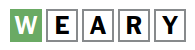

A letter of the guess word will be colored yellow if the letter is in the answer word but is in the incorrect position.

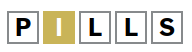

A letter of the guess word will be colored grey if the letter is not in the answer word.

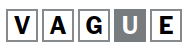

**Note** - A letter may also be colored grey if it appears $n$ times in the answer word and it is the $i$th occurence of the letter in the guess word where $i > n$.

### String Representation

For the purpose of our implementation, we would like a emthod for representing wordle hints in a text format.

1. A grey letter at position $i$ will be indicated with an '_' at position $i$ of the hint text.

2. A yellow letter at position $i$ will be indicated with an 'O' at position $i$ of the hint text.

3. A green letter at position $i$ will be indicated with an 'X' at position $i$ of the hint text.

### Numerical Representation

We would also like an intermendiate representation with a unique numerical value for each hint, a "hint ID". We can construct a 5-digit base-3 number with the following rules:

1. The $i$th digit of the hint ID will be 0 if the hint has a grey letter at position $i$

2. The $i$th digit of the hint ID will be 1 if the hint has a yellow letter at position $i$

3. The $i$th digit of the hint ID will be 2 if the hint has a green letter at position $i$

In [5]:
def get_hint(guess, answer):
    """
    Build the numerical base-3 representation of the hint based by adding consecutive digits.
    
    :param guess: a 5-letter guess word
    :param answer: a 5-letter answer word
    :return: an integer representing the hint resulting from comparing the guess word to the answer word
    """
    
    hint = 0
    answer_counts = Counter(answer)
    for guess_char, answer_char in zip(guess, answer):
        hint *= 3        
        
        # we don't need to include the "hint += 0" case since it leaves "hint" unchanged   
        if answer_counts[guess_char] > 0:
            answer_counts[guess_char] -= 1
            
            if guess_char != answer_char:
                hint += 1
            else:
                hint += 2        

    return hint

In [6]:
example_hint = get_hint("aroma", "alter")
np.base_repr(example_hint, base=3) # this displays the number in base-3

'21000'

In [7]:
def hint_to_str(hint):
    """
    Converts a numerical hint representation to a string representation.
    
    :param hint: a hint as an integer
    :return: a string representation of the input hint
    """
    
    chars = ["_", "O", "X"]
    base_3_repr = np.base_repr(hint, base=3)
    base_3_repr = (max(0, 5 - len(base_3_repr)) * "0") + base_3_repr # pad the number with extra zeros
    digits = [int(digit) for digit in base_3_repr]
    hint_str = "".join(chars[digit] for digit in digits)
    return hint_str

In [8]:
def str_to_hint(hint_str):
    """
    Converts a string hint representation to a numerical representation.
    
    :param hint_str: a hint as a string
    :return: the numerical representation of hint_str
    """
    
    hint = 0
    for char in hint_str:
        hint *= 3
        
        if char == 'O':
            hint += 1
        
        if char == 'X':
            hint += 2
        
        # we don't need to include the "hint += 0" case since it leaves "hint" unchanged
    
    return hint

In [9]:
hint_str = hint_to_str(example_hint)
hint_str

'XO___'

In [10]:
example_hint = str_to_hint(hint_str)
np.base_repr(example_hint, base=3) # this displays the number in base-3

'21000'

### Hint Array

Since building the hint for a particular guess-answer combination can become costly when done repeatitively, it is faster to pre-load a "hint array" that stores the results of evaluating all possible guess and answer word combinations.

Additionally, in "hard mode" wordle does not allow the player to guess a word which doesn't fit the criteria of the previous hints. It is therefore useful to also construct a guess-to-guess hint array for determining which guesses are still viable.

In [11]:
def build_hint_array(guess_list=None, answer_list=None, save_path=None):
    """
    Constructs an 2D array of hint values based on a list of guess words and a list of answer words. 
    The hint value at location (i, j) of the array is the hint that results from the ith guess word and jth answer word in their respective lists.
    
    :param guess_list: a list of guess words
    :param answer_list: a list of answer words
    :param save_path: if not None, then the filepath to a save file where the matrix can be saved
    :return: an array of hint values (integers)
    """
    
    n_guesses, n_answers = len(guess_list), len(answer_list)
    hint_array = np.zeros((n_guesses, n_answers), dtype=int)

    for i in tqdm_notebook(range(n_guesses)):
        guess = guess_list[i]
        for j in range(n_answers):
            answer = answer_list[j]
            hint_array[i,j] = get_hint(guess, answer)
    
    if save_path is not None:
        np.save(save_path, hint_matrix)
    
    return hint_matrix

In [12]:
# This is the location where we will cache the hint array(s)

GUESS_ANSWER_HINTS = "data/guess-answer-hints.npy" # this stores the hint array between guess and answer words
GUESS_GUESS_HINTS = "data/guess-guess-hints.npy" # this stores the hint array between guess words (and other guess words)

In [13]:
# here we calculate the hint array between guess and answer words

# guess_answer_hints = build_hint_array(guess_list, answer_list, GUESS_ANSWER_HINTS) # uncomment this line to make a new guess-answer-hints.npy file
guess_answer_hints = np.load(GUESS_ANSWER_HINTS)
guess_answer_hints.shape

(12972, 2315)

In [14]:
# for hard mode it is easier to have a guess-to-guess hint matrix in order to eliminate non-viable guesses

# gg_hint_array = build_hint_array(guess_list, guess_list, GUESS_GUESS_HINTS) # uncomment this line to make a new guess-guess-hints.npy file
guess_guess_hints = np.load(GUESS_GUESS_HINTS)
guess_guess_hints.shape

(12972, 12972)

## Calculating Word Entropy

Given a guess word, $g$, there is an associated distribution of hints that result from evaluating the guess word with all possible answer words (we will assume that an answer word is chosen uniformly at random). If a hint $h$ appears $k_h$ times in a $g$'s distribution, then recieving $k_h$ narrows down the set of answer words to $k_h$ possibilities.

In the extreme case where $k_h=1$ for all hints for all hints that can result from $g$, then entering $g$ will immediately reveal the answer word. On the opposite extreme, all possible hints are the same, then receiving that hint will reveal no information about the answer word.

The size of $k_h$ alone does not tell us if $h$ is a "good" or "bad" hint, instead it is more useful to know its proportion relative to the total number of number of potential hints. This is the same as the number of answer words, since there is a hint for each answer. Let $n$ be the number of hints/answer words.

Then $p_h = \frac{k_h}{n}$ is both the probability of recieving a pariticular hint, and a measurement of how much it will narrow down the set of possible answers. In other words, $p_h$ is inversely proportional to how informative a hint is, or how much information it carries.

We say that an event that occurs with probability $p$ has information $I$ where:

$$
I = -\log(p)
$$

The expected information recieved from a distribution of events is called the entropy of a distribution:

$$
H = \sum_{i=1} p_i I_i = - \sum_{i=1}^n p_i \log(p_i)
$$

The events with which we are concerned are the hints recieved after making a guess. We would like to maximize the expected information that we will recieve from a particular hint after making a guess. We therefore want to find the guess word with the hint distribution that has the higher entropy.

In [15]:
def sort_by_entropy(guess_idxs, entropies):
    sorted_args = np.argsort(entropies)[::-1]
    return guess_idxs[sorted_args], entropies[sorted_args]

In [16]:
def get_entropies(guess_answer_hints, guess_idxs=None):
    n_guesses = guess_answer_hints.shape[0] if guess_idxs is None else guess_idxs.shape[0]
    guess_idxs = np.arange(n_guesses) if guess_idxs is None else guess_idxs
    
    entropies = np.zeros(n_guesses, dtype=float)
    for i in range(n_guesses):
        guess_idx = guess_idxs[i]
        hints = guess_answer_hints[guess_idx]
        hint_counts = np.bincount(hints)
        entropies[i] = entropy(hint_counts)
    
    return guess_idxs, entropies

In [17]:
guess_idxs, entropies = get_entropies(guess_answer_hints)
guess_idxs, entropies = sort_by_entropy(guess_idxs, entropies)
entropies

array([4.07983666, 4.0776319 , 4.07425653, ..., 1.32893772, 1.23355995,
       1.17904679])

In [18]:
def display_guess_entropies(guess_idxs, guess_list, entropies, cutoff=20, base=2):
    guess_idxs, entropies = sort_by_entropy(guess_idxs, entropies)
    entropies = entropies / np.log(base)
    n_guesses = guess_idxs.shape[0]
    print(f"Here are the {min(cutoff, n_guesses)} guesses with the highest entropies\n")
    print(f" Word | Entropy (Base {'e' if None else base})")
    print(f"------|--------------------")
    for i in range(min(cutoff, n_guesses)):
        guess_idx = guess_idxs[i]
        guess = guess_list[guess_idx]
        entropy_val = entropies[i]
        print(f"{guess} | {entropy_val:0.5f}")
    print()

In [19]:
display_guess_entropies(guess_idxs, guess_list, entropies)

Here are the 20 guesses with the highest entropies

 Word | Entropy (Base 2)
------|--------------------
SOARE | 5.88596
ROATE | 5.88278
RAISE | 5.87791
RAILE | 5.86571
REAST | 5.86546
SLATE | 5.85578
CRATE | 5.83487
SALET | 5.83458
IRATE | 5.83140
TRACE | 5.83055
ARISE | 5.82094
ORATE | 5.81716
STARE | 5.80728
CARTE | 5.79456
RAINE | 5.78671
CARET | 5.77671
ARIEL | 5.77517
TALER | 5.77061
CARLE | 5.77048
SLANE | 5.77018



### Recursive Entropy

Although the unconditional entropy of each guess word is a good indicator for how it will perform, the unconditional entropy only evaluates how well a guess will narrow down the set of solution words. It is possible that an initial guess word with a high entropy will result in all second guess-words having a low entropy. Therefore, rather than solely maximizing the entropy of the initial guess word, it is even more optimal to evaluate the joint entropy of a series of guesses. The entropy of each successive guess is conditioned on the the previous guesses and the entropies are summed in order to get the joint entropy.

This relationship is illustrated with the following equation;

$$
H(g_1, g_2, ..., g_k) = H(g_1) + H(g_2 | g_1) + H(g_3 | g_1, g_2) + ... + H(g_k | g_1, ..., g_{k-1})
$$

In [20]:
def get_joint_entropies(guess_answer_hints, guess_idxs=None, max_depth=None, curr_depth=0, guess_guess_hints=None, progress_bar=False):
    guess_idxs, entropies = get_entropies(guess_answer_hints, guess_idxs) # these are the initial unconditional entropies of each word
    n_guesses, n_answers = guess_idxs.shape[0], guess_answer_hints.shape[1]
    
    if (max_depth is None) or (curr_depth < max_depth):
        for i in tqdm_notebook(range(n_guesses)) if progress_bar else range(n_guesses):
            guess_idx = guess_idxs[i]
            hints = guess_answer_hints[guess_idx]
            hints, hint_counts = np.unique(hints, return_counts=True)
            hint_distribution = hint_counts / n_answers
            n_hints = hints.shape[0]

            best_conditioned_entropies = np.zeros(n_hints, dtype=float)
            for j in range(n_hints):
                print(f"\r~~~~~~~~~~ Evaluating hint {j+1}/{n_hints} at depth {curr_depth+1}/{max_depth} ~~~~~~~~~~", end="")
                hint = hints[j] # assume that this is the hint received in response to our current guess word
                
                possible_answers = (guess_answer_hints[guess_idx] == hint)
                nxt_guess_answer_hints = guess_answer_hints[:, possible_answers]

                nxt_guess_guess_hints, nxt_guess_idxs = None, None
                if guess_guess_hints is not None: # if a guess-guess hint matrix is passed then we assume that we are in hard mode
                    possible_guesses = (guess_guess_hints[guess_idx] == hint)
                    nxt_guess_idxs = guess_idxs[possible_guesses]
                    nxt_guess_guess_hints = guess_guess_hints[:, possible_guesses]
                    
                _, conditioned_entropies = get_joint_entropies(nxt_guess_answer_hints, nxt_guess_idxs, max_depth, curr_depth+1, nxt_guess_guess_hints)
                best_conditioned_entropies[j] = 0. if conditioned_entropies.shape[0] == 0 else np.max(conditioned_entropies)

            entropies[i] += np.sum(best_conditioned_entropies * hint_distribution)
    
    return guess_idxs, entropies

In [57]:
# TODO: receive an error when increasing the depth

best_guess_idxs = guess_idxs[:30]
best_guess_idxs, joint_entropies = get_joint_entropies(guess_answer_hints, guess_guess_hints, best_guess_idxs, max_depth=1, progress_bar=True)

  0%|          | 0/30 [00:00<?, ?it/s]

~~~~~~~~~~ Evaluating hint 131/131 at depth 1/1 ~~~~~~~~~~

In [60]:
display_guess_entropies(best_guess_idxs, guess_list, joint_entropies)

Here are the 20 guesses with the highest entropies

 Word | Entropy (Base 2)
------|--------------------
ALERT | 9.23453
EARST | 9.13913
TASER | 9.05613
LEAST | 9.01524
ARTEL | 8.57525
CARSE | 8.45904
STARE | 8.42544
RAILE | 8.39177
RAISE | 8.38134
SALET | 8.36213
SOARE | 8.35057
CARET | 8.33438
ARISE | 8.30940
RAINE | 8.26716
ORATE | 8.25438
SLATE | 8.23891
IRATE | 8.23219
STRAE | 8.22238
CARTE | 8.22083
CARLE | 8.15705


## WORDLE REPL

To make a interacting with this code a little easier, we can create repl to run while solving the wordle. Since the recursive calculation of the joint entropies is slow we are only using the unconditional entropy of the initial guess word.

In [20]:
def validate_guess(guess, guess_to_idx, remaining_guesses, hard_mode):
    if len(guess) != 5:
        print(f"\"{guess}\" has length {len(guess)}, but wordle requires guesses of length 5")
        return False
    
    if not guess.isalpha():
        print(f"\"{guess}\" contains non-alphabetic characters, try another word")
        return False
    
    if guess not in guess_to_idx:
        print(f"\"{guess}\" is not in list of guess words, try another word")
        return False
    
    if (guess_to_idx[guess] not in remaining_guesses) and hard_mode:
        print(f"wordle is in hard mode and previous hints disqualify \"{guess}\"")
        return False
    
    return True

In [21]:
def validate_hint(hint_str, possible_hints):
    if len(hint_str) != 5:
        print(f"This hint has a length of {len(hint_str)}, but valid hints have a length of 5")
        return False
    
    valid_chars = ["_", "O", "X"]
    for char in hint_str:
        if char not in valid_chars:
            print(f"{char} is not a valid hint character {{\"_\", \"X\", \"O\"}}")
            return False
        
    if str_to_hint(hint_str) not in possible_hints:
        print(f"This hint is not possible given the game state and potential answer words")
        return False
    
    return True

In [25]:
GOAL_WORD = "ELUDE"
HARD_MODE = True

n_guesses, n_answers = len(guess_list), len(answer_list)

assert n_guesses == guess_answer_hints.shape[0] == guess_guess_hints.shape[0] == guess_guess_hints.shape[1]

assert n_answers == guess_answer_hints.shape[1]

state = "suggesting"
remaining_guesses = np.arange(n_guesses)
guess_answer_hints_cpy = guess_answer_hints.copy()
guess_guess_hints_cpy = guess_guess_hints.copy()
guess_counter = 0
while True:
    if state == "guessing":
        valid_guess = False
        while not valid_guess:
            guess = input("Enter a guess word: ").upper()
            valid_guess = validate_guess(guess, guess_to_idx, remaining_guesses, HARD_MODE)
        guess_counter += 1
        guess_idx = guess_to_idx[guess]
        answer_hints = guess_answer_hints_cpy[guess_idx]
        guess_hints = guess_guess_hints_cpy[guess_idx]
        state = "hinting"
    
    if state == "hinting":
        if GOAL_WORD is None:
            valid_hint = False
            while not valid_hint:
                hint_str = input("Enter the resulting hint: ").upper()
                valid_hint = validate_hint(hint_str, answer_hints)
            hint = str_to_hint(hint_str)
            
        else:
            hint = get_hint(guess, GOAL_WORD)
            print(f"The hint is \"{hint_to_str(hint)}\"\n")
            
        if hint == str_to_hint("XXXXX"):
            print(f"Congrats! You solved the wordle in {guess_counter} guesse(s)!")
            break
                
        guess_answer_hints_cpy = guess_answer_hints_cpy[:, answer_hints == hint]
        
        if HARD_MODE:
            possible_guesses = (guess_hints == hint)
            remaining_guesses = remaining_guesses[possible_guesses]
            guess_guess_hints_cpy = guess_guess_hints_cpy[:, possible_guesses]
            
        state = "suggesting"
        
    
    if state == "suggesting":
        n_remaining_answers = guess_answer_hints_cpy.shape[1]
        
        if n_remaining_answers == 0:
            print(f"Something is wrong, there are no possible answers remaining")
            break
        
        if n_remaining_answers == 1:
            answer_idx = np.where(guess_answer_hints_cpy == str_to_hint("XXXXX"))[0][0]
            answer = guess_list[answer_idx]
            print(f"There is one possible answer word left: \"{answer}\"\n")

        if n_remaining_answers > 1:
            guess_idxs = None if not HARD_MODE else remaining_guesses
            guess_idxs, entropies = get_entropies(guess_answer_hints_cpy, guess_idxs)
            display_guess_entropies(guess_idxs, guess_list, entropies)
        
        state = "guessing"

Here are the 20 guesses with the highest entropies

 Word | Entropy (Base 2)
------|--------------------
SOARE | 5.88596
ROATE | 5.88278
RAISE | 5.87791
RAILE | 5.86571
REAST | 5.86546
SLATE | 5.85578
CRATE | 5.83487
SALET | 5.83458
IRATE | 5.83140
TRACE | 5.83055
ARISE | 5.82094
ORATE | 5.81716
STARE | 5.80728
CARTE | 5.79456
RAINE | 5.78671
CARET | 5.77671
ARIEL | 5.77517
TALER | 5.77061
CARLE | 5.77048
SLANE | 5.77018



Enter a guess word:  soare


The hint is "____X"

Here are the 20 guesses with the highest entropies

 Word | Entropy (Base 2)
------|--------------------
TUILE | 4.68492
GUILE | 4.53567
UTILE | 4.50279
ELITE | 4.37601
TILDE | 4.29589
LIGNE | 4.22052
NUDIE | 4.21959
EIGNE | 4.21917
CUTIE | 4.21602
DEICE | 4.20225
TINGE | 4.20182
EDILE | 4.19749
TENUE | 4.19705
CLINE | 4.19122
MULIE | 4.14364
DULCE | 4.14172
LIEGE | 4.13156
CHILE | 4.13090
DIENE | 4.12987
ELIDE | 4.12155



Enter a guess word:  tuile


The hint is "_O_OX"

Here are the 8 guesses with the highest entropies

 Word | Entropy (Base 2)
------|--------------------
FLUME | 2.00000
PLUME | 1.50000
FLUKE | 1.50000
GLUME | 1.00000
BLUME | 1.00000
KLUGE | 0.81128
ELUDE | 0.81128
BLUDE | 0.81128



Enter a guess word:  flume


The hint is "_XX_X"

There is one possible answer word left: "ELUDE"



Enter a guess word:  elude


The hint is "XXXXX"

Congrats! You solved the wordle in 4 guesse(s)!
